In [18]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [19]:
# Configuración de estilos para gráficas
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

In [20]:
# Cargar el dataset de incendios forestales
print("Cargando datos...")
df = pd.read_csv('forestfires.csv')

# Mostrar información general del dataset
print("\n----- INFORMACIÓN DEL DATASET -----")
print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nPrimeras 5 filas:")
print(df.head())

Cargando datos...

----- INFORMACIÓN DEL DATASET -----
Dimensiones: 517 filas, 13 columnas

Primeras 5 filas:
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


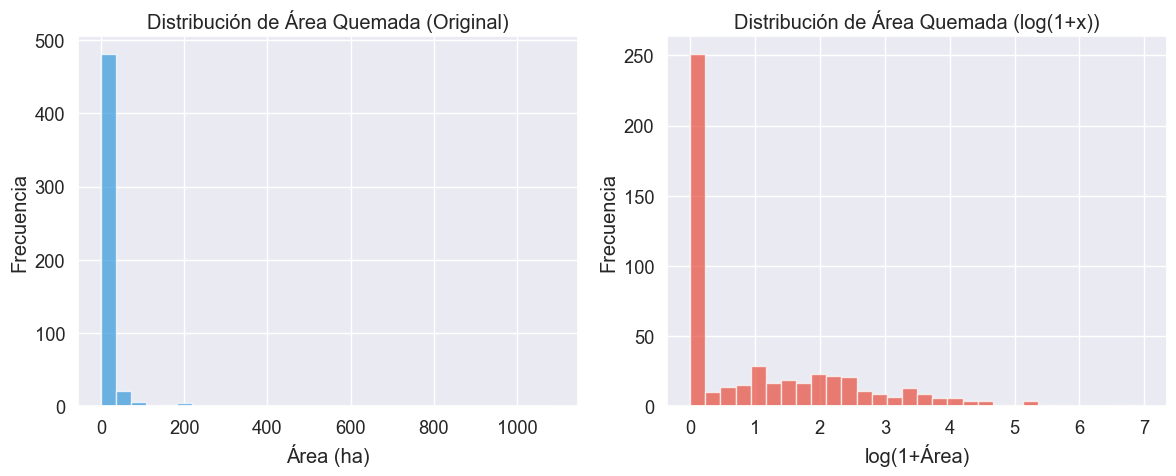


Gráfico de distribución mostrado
Estadísticas de área quemada: Min=0.00, Max=1090.84, Media=12.85
Porcentaje de incendios con área=0: 47.78%


In [23]:
# Analizar la distribución de la variable objetivo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['area'], bins=30, color=colors[0], alpha=0.7)
plt.title('Distribución de Área Quemada (Original)')
plt.xlabel('Área (ha)')
plt.ylabel('Frecuencia')

# Visualizar la distribución de área con transformación log
area_log = np.log1p(df['area'])
plt.subplot(1, 2, 2)
plt.hist(area_log, bins=30, color=colors[1], alpha=0.7)
plt.title('Distribución de Área Quemada (log(1+x))')
plt.xlabel('log(1+Área)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print("\nGráfico de distribución mostrado")
print(f"Estadísticas de área quemada: Min={df['area'].min():.2f}, Max={df['area'].max():.2f}, Media={df['area'].mean():.2f}")
print(f"Porcentaje de incendios con área=0: {100*sum(df['area']==0)/len(df):.2f}%")


----- PREPROCESAMIENTO DE DATOS -----
Aplicada transformación logarítmica a la variable objetivo (área)
Variables categóricas: ['month', 'day']
Variables numéricas: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


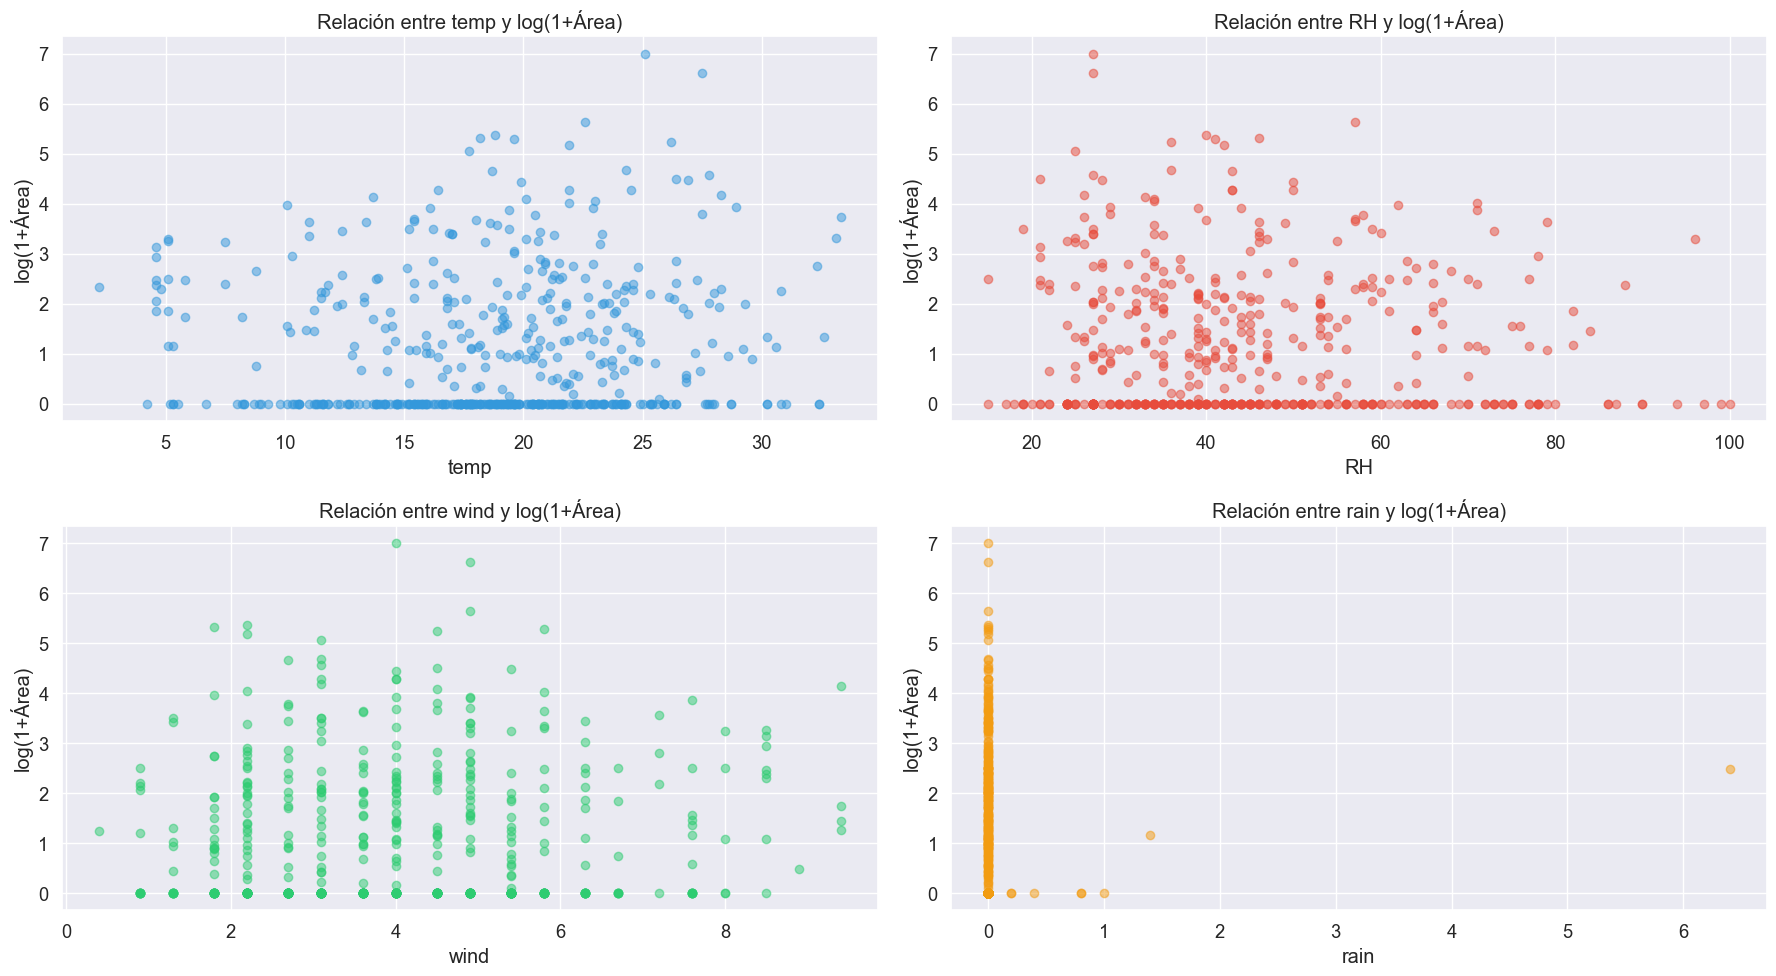

Gráfico de relaciones mostrado


In [26]:
# Procesamiento de datos
print("\n----- PREPROCESAMIENTO DE DATOS -----")
X = df.drop('area', axis=1)
y = df['area']

# Transformación logarítmica para manejar el sesgo en la variable objetivo
y_log = np.log1p(y)  # log(1+x)
print("Aplicada transformación logarítmica a la variable objetivo (área)")

# Identificar columnas numéricas y categóricas
categorical_cols = ['month', 'day']
numerical_cols = [col for col in X.columns if col not in categorical_cols]
print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")

# Visualizar relaciones entre algunas variables numéricas y el área
plt.figure(figsize=(18, 10))
for i, col in enumerate(['temp', 'RH', 'wind', 'rain']):
    plt.subplot(2, 2, i+1)
    plt.scatter(df[col], np.log1p(df['area']), alpha=0.5, color=colors[i])
    plt.title(f'Relación entre {col} y log(1+Área)')
    plt.xlabel(col)
    plt.ylabel('log(1+Área)')
plt.tight_layout()
plt.show()
print("Gráfico de relaciones mostrado")

In [27]:
# Crear pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Aplicar transformaciones
print("Aplicando normalización y one-hot encoding...")
X_processed = preprocessor.fit_transform(X)
print(f"Dimensiones después del preprocesamiento: {X_processed.shape}")

# Dividir en conjuntos de entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_log, test_size=0.2, random_state=42)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Aplicando normalización y one-hot encoding...
Dimensiones después del preprocesamiento: (517, 29)
Conjunto de entrenamiento: 413 muestras
Conjunto de prueba: 104 muestras


In [28]:
# Definir arquitectura del modelo
print("\n----- ARQUITECTURA DEL MODELO -----")
D_in = X_train.shape[1]  # Dimensión de entrada después del preprocesamiento
H1, H2, D_out = D_in, 100, 50  # Misma estructura que el modelo MNIST pero con dimensiones apropiadas
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, 1),  # Salida de 1 neurona para regresión
)

print(f"Entrada: {D_in} características")
print(f"Capa oculta 1: {H1} neuronas")
print(f"Capa oculta 2: {H2} neuronas")
print(f"Salida: 1 neurona (regresión)")

# Mover modelo a GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Usando dispositivo: {device}")


----- ARQUITECTURA DEL MODELO -----
Entrada: 29 características
Capa oculta 1: 29 neuronas
Capa oculta 2: 100 neuronas
Salida: 1 neurona (regresión)
Usando dispositivo: cuda


In [29]:
# Convertir datos a tensores y mover a GPU
X_t = torch.tensor(X_train, dtype=torch.float).to(device)
Y_t = torch.tensor(y_train.values, dtype=torch.float).to(device).reshape(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float).to(device)
Y_test_t = torch.tensor(y_test.values, dtype=torch.float).to(device).reshape(-1, 1)

In [30]:
# Definir función de error MSE para regresión
def mse_loss(output, target):
    return torch.mean((output - target) ** 2)

# MODIFICACIÓN: Nueva función para calcular la precisión basada en error relativo porcentual
def calculate_accuracy(mse, variance):
    # Calculamos el error normalizado (NRMSE)
    rmse = np.sqrt(mse)
    mean_target = torch.mean(Y_test_t).item()
    
    # Evitamos división por cero
    if mean_target == 0:
        mean_target = 1e-6
        
    # Error relativo como porcentaje
    relative_error = (rmse / mean_target) * 100
    
    # Convertimos a precisión: 100% - error_relativo (limitado a 0-100%)
    accuracy = max(0, min(100, 100 - relative_error))
    
    return accuracy

In [36]:
# Calcular la varianza del conjunto de prueba para normalizar el error
target_variance = torch.var(Y_test_t).item()
target_mean = torch.mean(Y_test_t).item()
print(f"Media del conjunto de prueba: {target_mean:.5f}")
print(f"Varianza del conjunto de prueba: {target_variance:.5f}")

# Bucle de entrenamiento manual
print("\n----- ENTRENAMIENTO CON GRADIENTE MANUAL -----")
epochs = 35000
lr = 0.01  # Ajustada para regresión
log_each = 10
train_losses = []
test_losses = []
accuracies = []
epoch_list = []

model.train()
for e in range(1, epochs + 1):
    # forward
    y_pred = model(X_t)
    
    # loss
    loss = mse_loss(y_pred, Y_t)
    train_losses.append(loss.item())
    
    # ponemos a cero los gradientes
    model.zero_grad()
    
    # Backprop
    loss.backward()
    
    # update de los pesos
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    
    if not e % log_each:
        # Evaluar en conjunto de prueba
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = mse_loss(test_pred, Y_test_t).item()

            # Calcular precisión como R² score
            ss_res = torch.sum((Y_test_t - test_pred) ** 2)
            ss_tot = torch.sum((Y_test_t - torch.mean(Y_test_t)) ** 2)
            
            # R² score
            r2_score = (ss_res / ss_tot)-1
            accuracy = r2_score.item() * 100  # Convertir a porcentaje

            test_losses.append(test_loss)
            accuracies.append(accuracy)
            epoch_list.append(e)
        model.train()
        print(f"Epoch {e}/{epochs} | Loss: {np.mean(train_losses[-log_each:]):.5f} | Precisión: {accuracy:.2f}%")


Media del conjunto de prueba: 1.14051
Varianza del conjunto de prueba: 2.21920

----- ENTRENAMIENTO CON GRADIENTE MANUAL -----
Epoch 10/35000 | Loss: 0.01164 | Precisión: 98.77%
Epoch 20/35000 | Loss: 0.01163 | Precisión: 98.77%
Epoch 30/35000 | Loss: 0.01163 | Precisión: 98.78%
Epoch 40/35000 | Loss: 0.01162 | Precisión: 98.78%
Epoch 50/35000 | Loss: 0.01161 | Precisión: 98.79%
Epoch 60/35000 | Loss: 0.01160 | Precisión: 98.80%
Epoch 70/35000 | Loss: 0.01159 | Precisión: 98.81%
Epoch 80/35000 | Loss: 0.01158 | Precisión: 98.81%
Epoch 90/35000 | Loss: 0.01157 | Precisión: 98.82%
Epoch 100/35000 | Loss: 0.01156 | Precisión: 98.83%
Epoch 110/35000 | Loss: 0.01155 | Precisión: 98.83%
Epoch 120/35000 | Loss: 0.01155 | Precisión: 98.84%
Epoch 130/35000 | Loss: 0.01154 | Precisión: 98.85%
Epoch 140/35000 | Loss: 0.01153 | Precisión: 98.85%
Epoch 150/35000 | Loss: 0.01153 | Precisión: 98.86%
Epoch 160/35000 | Loss: 0.01153 | Precisión: 98.87%
Epoch 170/35000 | Loss: 0.01152 | Precisión: 98.87

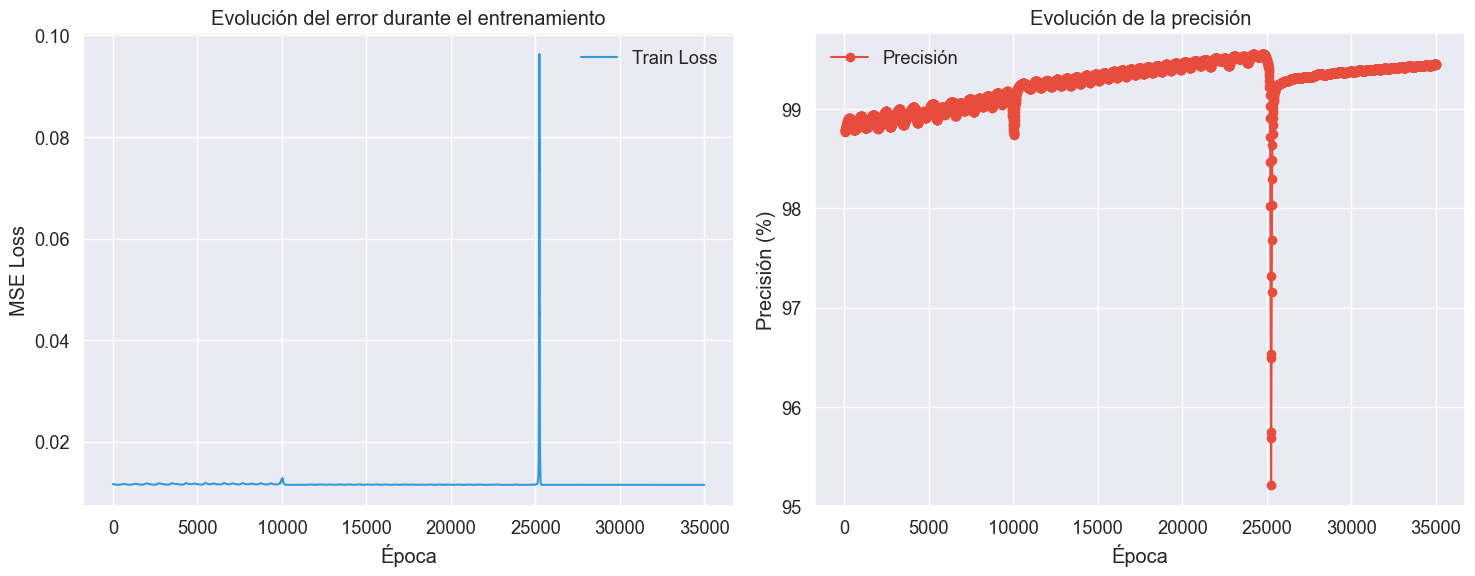

Gráficos de métricas mostrados


In [37]:
# Gráfico de la pérdida y precisión durante el entrenamiento manual
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, color=colors[0], label='Train Loss')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.title('Evolución del error durante el entrenamiento')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, accuracies, color=colors[1], marker='o', label='Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Evolución de la precisión')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("Gráficos de métricas mostrados")

In [40]:
# Función de evaluación
def evaluate(x, y_true):
    model.eval()
    with torch.no_grad():
        y_pred = model(x)
        mse = torch.mean((y_pred - y_true) ** 2).item()
        
        # Calculamos el R² score
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        
        # R² score para la precisión
        r2_score =  (ss_res / ss_tot)-1
        accuracy = r2_score.item() * 100  # Convertir a porcentaje
        
    return y_pred, mse, accuracy

# Evaluar modelo manual
y_pred_manual, test_mse_manual, accuracy_manual = evaluate(X_test_t, Y_test_t)
print(f"\nResultados finales (entrenamiento manual):")
print(f"MSE: {test_mse_manual:.5f}")
print(f"RMSE: {np.sqrt(test_mse_manual):.5f}")
print(f"Precisión: {accuracy_manual:.2f}%")



Resultados finales (entrenamiento manual):
MSE: 4.38359
RMSE: 2.09370
Precisión: 99.45%



----- ENTRENAMIENTO CON OPTIMIZADOR PYTORCH -----
Epoch 50/9000 | Loss: 2.18618 | Precisión: -0.45%
Epoch 100/9000 | Loss: 1.86879 | Precisión: -1.31%
Epoch 150/9000 | Loss: 1.84955 | Precisión: -1.79%
Epoch 200/9000 | Loss: 1.83286 | Precisión: -2.15%
Epoch 250/9000 | Loss: 1.81668 | Precisión: -2.48%
Epoch 300/9000 | Loss: 1.80034 | Precisión: -2.79%
Epoch 350/9000 | Loss: 1.78331 | Precisión: -3.05%
Epoch 400/9000 | Loss: 1.76604 | Precisión: -3.29%
Epoch 450/9000 | Loss: 1.74833 | Precisión: -3.53%
Epoch 500/9000 | Loss: 1.73033 | Precisión: -3.73%
Epoch 550/9000 | Loss: 1.71212 | Precisión: -3.88%
Epoch 600/9000 | Loss: 1.69344 | Precisión: -3.91%
Epoch 650/9000 | Loss: 1.67462 | Precisión: -3.87%
Epoch 700/9000 | Loss: 1.65519 | Precisión: -3.84%
Epoch 750/9000 | Loss: 1.63528 | Precisión: -3.75%
Epoch 800/9000 | Loss: 1.61483 | Precisión: -3.53%
Epoch 850/9000 | Loss: 1.59364 | Precisión: -3.18%
Epoch 900/9000 | Loss: 1.57224 | Precisión: -2.69%
Epoch 950/9000 | Loss: 1.55081 |

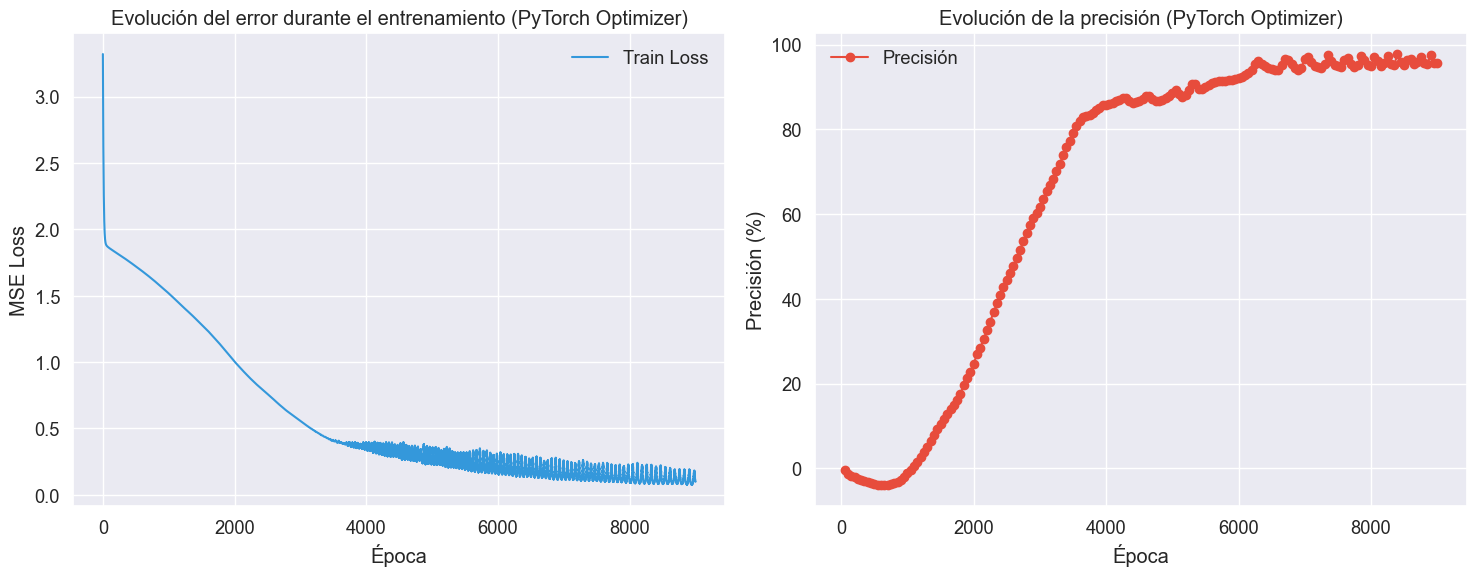

Gráficos de métricas mostrados


In [46]:
# Versión con optimizador de PyTorch
print("\n----- ENTRENAMIENTO CON OPTIMIZADOR PYTORCH -----")

# Reiniciar modelo
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, 1),
).to(device)

# Definir criterio y optimizador
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Bucle de entrenamiento
epochs = 9000
log_each = 50
train_losses = []
test_losses = []
accuracies = []
epoch_list = []

model.train()
for e in range(1, epochs+1):
    # forward
    y_pred = model(X_t)
    
    # loss
    loss = criterion(y_pred, Y_t)
    train_losses.append(loss.item())
    
    # ponemos a cero los gradientes
    optimizer.zero_grad()
    
    # Backprop
    loss.backward()
    
    # update de los pesos
    optimizer.step()
    
    if not e % log_each:
        # Calcular precisión en conjunto de prueba
        _, test_mse, accuracy = evaluate(X_test_t, Y_test_t)
        test_losses.append(test_mse)
        accuracies.append(accuracy)
        epoch_list.append(e)
        print(f"Epoch {e}/{epochs} | Loss: {np.mean(train_losses[-log_each:]):.5f} | Precisión: {accuracy:.2f}%")

# Gráfico de la pérdida y precisión durante el entrenamiento con optimizador
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, color=colors[0], label='Train Loss')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.title('Evolución del error durante el entrenamiento (PyTorch Optimizer)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, accuracies, color=colors[1], marker='o', label='Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Evolución de la precisión (PyTorch Optimizer)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("Gráficos de métricas mostrados")

# Evaluación final
y_pred_final, test_mse_final, final_accuracy = evaluate(X_test_t, Y_test_t)
